In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import RobustScaler
# Imbalanced Data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

# Pre-Processing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

# Load the data

In [2]:
df = pd.read_csv("data/diabetic_data.csv")
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


# Get some info from the data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [4]:
df.shape

(101766, 50)

# Look at the hist from the numerical variables

array([[<AxesSubplot:title={'center':'encounter_id'}>,
        <AxesSubplot:title={'center':'patient_nbr'}>,
        <AxesSubplot:title={'center':'admission_type_id'}>,
        <AxesSubplot:title={'center':'discharge_disposition_id'}>],
       [<AxesSubplot:title={'center':'admission_source_id'}>,
        <AxesSubplot:title={'center':'time_in_hospital'}>,
        <AxesSubplot:title={'center':'num_lab_procedures'}>,
        <AxesSubplot:title={'center':'num_procedures'}>],
       [<AxesSubplot:title={'center':'num_medications'}>,
        <AxesSubplot:title={'center':'number_outpatient'}>,
        <AxesSubplot:title={'center':'number_emergency'}>,
        <AxesSubplot:title={'center':'number_inpatient'}>],
       [<AxesSubplot:title={'center':'number_diagnoses'}>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

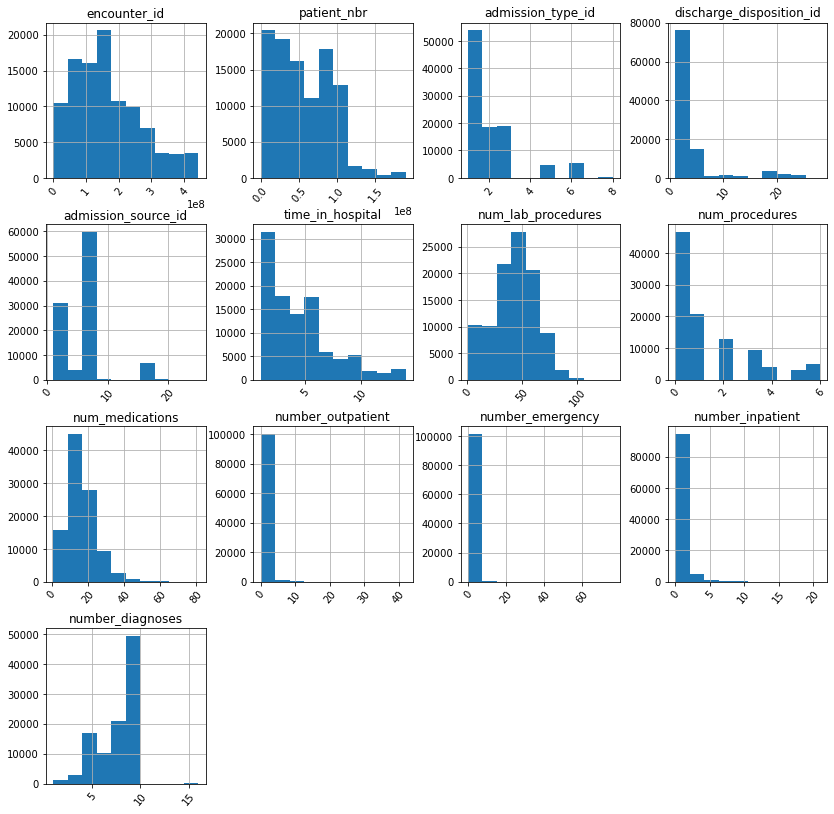

In [5]:
df.hist(figsize=(14,14), xrot=50)

# Get detail imformation from each column so we can replace miss values with imputation and or delated columns or row as appropriate

In [6]:
for i in df.columns[2:]:
    print(i)
    print(df[i].value_counts())
    print("-------------")

race
Caucasian          76099
AfricanAmerican    19210
?                   2273
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64
-------------
gender
Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64
-------------
age
[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64
-------------
weight
?            98569
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: weight, dtype: int64
-------------
admission_type_id
1    53990
3    18869
2    18480
6     5291
5     4785
8      320
7       21
4       10
Name: admission_type_id, dtype: int64
-------------
discharge_disposition_id
1     60234
3     13954
6     12902
18  

# First drop the unnecesary columns

First delate the columns that are id of the patients or encounter, so they are usefull for the model, and the columns of weight which is important but the amount of missing values is too much to make it an useful variable, there is 96% of missing values. We also delete the examide medication and citoglipton medication because there is only the no variable, there is not any yes value

In [7]:
l=df["weight"].value_counts(normalize=True)*100
l

?            96.858479
[75-100)      1.312816
[50-75)       0.881434
[100-125)     0.614154
[125-150)     0.142484
[25-50)       0.095317
[0-25)        0.047167
[150-175)     0.034393
[175-200)     0.010809
>200          0.002948
Name: weight, dtype: float64

In [8]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [9]:
df_reduced= df.drop(columns=['encounter_id','patient_nbr','weight','payer_code', 'medical_specialty', 'examide','citoglipton'])
df_reduced.shape
df_reduced.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),6,25,1,1,41,0,1,...,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,...,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


# Binning of the dig 1 diag 2 and dig 3

In [11]:
# Function to Categorize DX based on URL ...
def bin_dx(code):
    try:
        code = float(code)
    except:
        code = 0

    # Circulatory
    if code in range(390,460) or code == 785:
        return("Circulatory")

    # Respiratory
    elif code in range(460,520) or code == 786:
        return("Respiratory")

    # Digestive
    elif code in range(520,580) or code == 787:
        return("Digestive")

    # Diabetes
    elif code >= 250 and code < 251:
        return("Diabetes")

    # Injury
    elif code in range(800,1000):
        return("Injury")

    # Musculoskeletal
    elif code in range(710,740):
        return("Musculoskeletal")

    # Genitourinary
    elif code in range(580,630) or code == 788:
        return("Genitourinary")

    # Neoplasms
    elif code in range(140,240):
        return("Neoplasms")
    elif code in range(780,783) or code == 784:
        return("Neoplasms")
    elif code in range(790,800):
        return("Neoplasms")
    elif code in range(240,250):
        return("Neoplasms")
    elif code in range(251,280):
        return("Neoplasms")
    elif code in range(680,710):
        return("Neoplasms")
    elif code in range(1,140):
        return("Neoplasms")
    elif code in range(290,320):
        return("Neoplasms")

    # Other
    else:
        return("Other")

In [12]:
df_reduced["Diag1"] = df_reduced["diag_1"].apply(bin_dx)
df_reduced["Diag2"] = df_reduced["diag_2"].apply(bin_dx)
df_reduced["Diag3"] = df_reduced["diag_3"].apply(bin_dx)


print(df_reduced["Diag1"].value_counts())
print("")
print(df_reduced["Diag2"].value_counts())
print("")
print(df_reduced["Diag3"].value_counts())

Circulatory        30437
Neoplasms          16318
Respiratory        14423
Digestive           9475
Diabetes            8757
Injury              6974
Other               5308
Genitourinary       5117
Musculoskeletal     4957
Name: Diag1, dtype: int64

Circulatory        31881
Neoplasms          21462
Diabetes           12794
Respiratory        10895
Genitourinary       8376
Other               7996
Digestive           4170
Injury              2428
Musculoskeletal     1764
Name: Diag2, dtype: int64

Circulatory        30306
Neoplasms          20985
Diabetes           17157
Other              11489
Respiratory         7358
Genitourinary       6680
Digestive           3930
Injury              1946
Musculoskeletal     1915
Name: Diag3, dtype: int64


In [13]:
df_reduced = df_reduced.drop(columns=['diag_1', 'diag_2', 'diag_3'])

# We will bin the age variable

In [14]:
print(df_reduced["age"].value_counts())
di = {'[70-80)': 'Old', '[60-70)': 'Old', '[80-90)': 'Old', '[90-100)': 'Old', '[50-60)': 'Midage', '[40-50)': 'Midage', '[30-40)': 'Young', '[20-30)': 'Young', '[10-20)': 'Young', '[0-10)': 'Young'}

df_reduced["age"].replace(di, inplace=True)
print(df_reduced["age"].value_counts())
 

[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64
Old       68541
Midage    26941
Young      6284
Name: age, dtype: int64


# We will replace the missing values from the reminder column

I there is a discrete or categorical values we will replace with the mode, if there is a continous variable we will replace with the mean

In [16]:
# reagenge the id coluns can be useful in a way that all the missing values is place in one place and make it categorical
# admission_type_id
df_reduced.admission_type_id.replace(to_replace = 5, value = 6, inplace = True)
df_reduced.admission_type_id.replace(to_replace = 8, value = 6, inplace = True)
df_reduced.admission_type_id = df_reduced.admission_type_id.astype(str)

# admission_source_id
df_reduced.admission_source_id.replace(to_replace = 9, value = 17, inplace = True)
df_reduced.admission_source_id.replace(to_replace = 15, value = 17, inplace = True)
df_reduced.admission_source_id.replace(to_replace = 20, value = 17, inplace = True)
df_reduced.admission_source_id.replace(to_replace = 21, value = 17, inplace = True)
df_reduced.admission_source_id= df_reduced.admission_source_id.astype(str)

# Next, we remove observations where the discharge disposition is related to hospice or death since these will not add to the possibility of being readmitted.


In [17]:
indexNames = df_reduced[df_reduced['discharge_disposition_id'].isin([11,13,14,19,20,21])].index
df_reduced.drop(indexNames, inplace=True)

print(df_reduced['discharge_disposition_id'].value_counts())

1     60234
3     13954
6     12902
18     3691
2      2128
22     1993
5      1184
25      989
4       815
7       623
23      412
28      139
8       108
15       63
24       48
9        21
17       14
16       11
10        6
27        5
12        3
Name: discharge_disposition_id, dtype: int64


# Make the result binary

In [18]:
di = {'NO': 0, '>30': 0, '<30': 1}

df_reduced["readmitted"].replace(di, inplace=True)
print(df_reduced["readmitted"].value_counts())

0    88029
1    11314
Name: readmitted, dtype: int64


# One Hot encode the categorical values and scale the continous variables

In [19]:
"""categorical_values= ['race', 'gender', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide','chlorpropamide',
                     'glimepiride', 'acetohexamide', 'glipizide','glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose','miglitol', 'troglitazone', 'tolazamide', 'insulin',
                    'glyburide-metformin', 'glipizide-metformin','glimepiride-pioglitazone', 'metformin-rosiglitazone',
                    'metformin-pioglitazone', 'change', 'diabetesMed', 'Diag1', 'Diag2','Diag3', 'Age', 'admission_type_id', 'discharge_disposition_id','admission_source_id']



numeric_value= ['time_in_hospital', 'num_lab_procedures','num_procedures', 'num_medications', 'number_outpatient',
                'number_emergency', 'number_inpatient', 'number_diagnoses',]
"""

In [51]:
"""from sklearn.preprocessing import OneHotEncoder
# categorical
ohe = OneHotEncoder()
X_object = df_reduced.select_dtypes('object')
ohe.fit(X_object)
codes = ohe.transform(X_object).toarray()
feature_names = ohe.get_feature_names(X_object.columns)

# integer scaled
x_int= df_reduced.select_dtypes(exclude='object')
min_max_scaler = RobustScaler()
x_int = min_max_scaler.fit_transform(x_int)
feature_names_i =df_reduced.select_dtypes(exclude='object').columns 

fr = pd.concat([pd.DataFrame(x_int ,columns=feature_names_i), 
               pd.DataFrame(codes,columns=feature_names).astype(int)], axis=1)"""

# Bulding the model with the pipeline using one hot encoder inside the pipeline

In [20]:
categorical_features = ['race', 'gender', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide','chlorpropamide',
                        'glimepiride', 'acetohexamide', 'glipizide','glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 
                        'acarbose','miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
                        'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed',
                        'Diag1', 'Diag2','Diag3', 'age', 'admission_type_id', 'discharge_disposition_id','admission_source_id']

numeric_features = ['time_in_hospital', 'num_lab_procedures','num_procedures', 'num_medications', 'number_outpatient', 
                    'number_emergency', 'number_inpatient', 'number_diagnoses']

X = df_reduced[categorical_features + numeric_features]
y = df_reduced['readmitted']

# Verify shapes
print(df_reduced.shape)
print(X.shape)
print(y.shape)

(99343, 43)
(99343, 42)
(99343,)


In [111]:
"""results_LR = pd.DataFrame(model_grid_search.cv_results_['params'])
results_LR['test_score'] = model_grid_search.cv_results_['mean_test_score']
results_LR """

"results_LR = pd.DataFrame(model_grid_search.cv_results_['params'])\nresults_LR['test_score'] = model_grid_search.cv_results_['mean_test_score']\nresults_LR "

In [21]:

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('scaler', RobustScaler(with_centering=False))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


pipeline = imbpipeline(steps = [['preprocessor', preprocessor],
                                ['smote', SMOTE(random_state=11)],
                                ##['scaler', RobustScaler(with_centering=False)],
                                ['classifier', LogisticRegression(random_state=11,
                                                                  max_iter=1000)]])

stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

param_grid = {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'classifier__penalty': ['l1', 'l2']}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}
              
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           #scoring=scorers,
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

/Users/fabiosavorgnan/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan 0.64223231        nan 0.6399826         nan 0.63838013
        nan 0.63747927        nan 0.63725445        nan 0.63720697
        nan 0.63721367]
  category=UserWarning


Cross-validation score: 0.6422323088311607
Test score: 0.6491880831008632


# Print the grid best stimator

In [35]:
print(grid_search.best_params_)

{'classifier__C': 0.001, 'classifier__penalty': 'l2'}


# Using the grid best stimator to predict

In [41]:
y_hat= grid_search.best_estimator_.predict(X_test)
y_hat

array([0, 1, 0, ..., 0, 0, 0])

# Best classifier coef

In [58]:
"""classifier = ovr.named_steps['classifier']
classifier.coef_.shape"""

(1, 148)

In [33]:
import eli5

onehot_columns = list(grid_search.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(input_features=categorical_features))
numeric_features_list = list(numeric_features)
numeric_features_list.extend(onehot_columns)

eli5.explain_weights(grid_search.best_estimator_.named_steps['classifier'], top=50, feature_names=numeric_features_list)

Weight?,Feature
+0.500,discharge_disposition_id_22
+0.269,number_inpatient
+0.266,A1Cresult_None
+0.219,race_Caucasian
+0.159,age_Old
+0.158,number_diagnoses
+0.155,Diag1_Circulatory
+0.142,discharge_disposition_id_5
+0.137,admission_source_id_1
+0.136,glimepiride_No


# Performance of the modeel

In [42]:
# how did our model perform?
count_misclassified = (y_test != y_hat).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = mt.accuracy_score(y_test, y_hat)
print('Accuracy: {:.2f}'.format(accuracy))
precision = mt.precision_score(y_test, y_hat, average='micro')
print("Precision=", precision)
recal = mt.recall_score(y_test, y_hat, average='micro')
print("Recal=", recal)
fscore = mt.f1_score(y_test, y_hat, average='weighted')
print("fscore=",fscore )
# Confusion matrix
cm= confusion_matrix(y_test, y_hat)
print("Confusion Matrix =", cm)

Misclassified samples: 6818
Accuracy: 0.66
Precision= 0.6568523831093663
Recal= 0.6568523831093663
fscore= 0.7179368646243653
Confusion Matrix = [[11826  5780]
 [ 1038  1225]]


# Plot confusion matrix

Confusion matrix, without normalization
[[11826  5780]
 [ 1038  1225]]
Normalized confusion matrix
[[0.67 0.33]
 [0.46 0.54]]


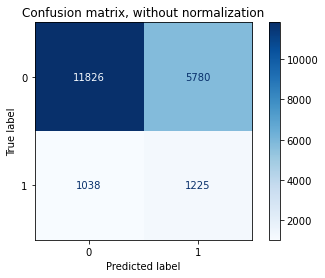

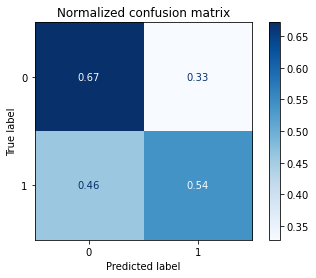

In [44]:

class_names = [0,1]

classifier = grid_search

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [48]:
from sklearn.metrics import classification_report

target_names = y_test.unique().astype(str)
probs_y = grid_search.predict_proba(X_test)
y_pred = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

vals = []

for val in probs_y[:,1]:
    if val > 0.4:
        vals.append(1)
    else:
        vals.append(0)

print(classification_report(y_test, vals, target_names=target_names))

              precision    recall  f1-score   support

           0       0.92      0.67      0.78     17606
           1       0.17      0.54      0.26      2263

    accuracy                           0.66     19869
   macro avg       0.55      0.61      0.52     19869
weighted avg       0.83      0.66      0.72     19869

              precision    recall  f1-score   support

           0       0.94      0.35      0.51     17606
           1       0.14      0.81      0.24      2263

    accuracy                           0.40     19869
   macro avg       0.54      0.58      0.37     19869
weighted avg       0.85      0.40      0.48     19869



# Plot ROC

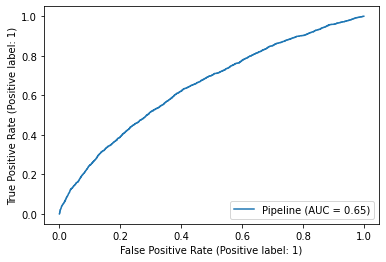

In [46]:
mt.plot_roc_curve(grid_search.best_estimator_, X_test, y_test)

In [47]:
probs_y = grid_search.predict_proba(X_test)
print(probs_y)

probs_y[:,1]

[[0.66 0.34]
 [0.39 0.61]
 [0.68 0.32]
 ...
 [0.74 0.26]
 [0.63 0.37]
 [0.61 0.39]]


array([0.34, 0.61, 0.32, ..., 0.26, 0.37, 0.39])

(0.0, 1.0)

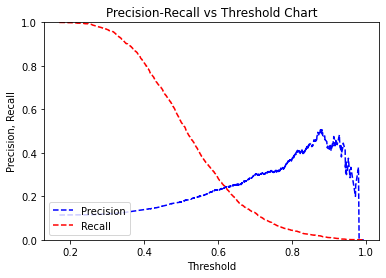

In [49]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:,1]) 

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

/Users/fabiosavorgnan/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [ nan 0.64  nan 0.64  nan 0.64  nan 0.64  nan 0.64  nan 0.64  nan 0.64]
  category=UserWarning


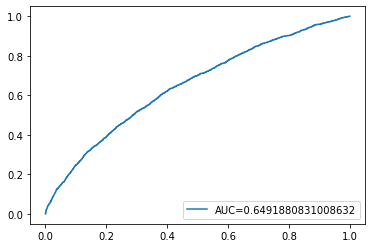

In [50]:
# classifier
classifier = grid_search.fit(X_train, y_train)
y_pred_proba = classifier.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()

# Tunning the threshold for classification


******** For i = 0.01 ******
0.11389601892395189
Precision= 0.11389601892395189
Recal= 0.11389601892395189
fscore= 0.023291766747235054
Confusion Matrix = [[    0 17606]
 [    0  2263]]


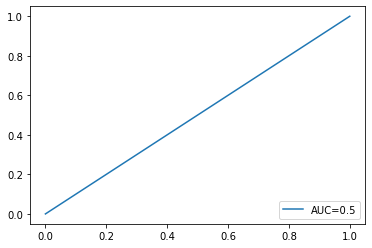


******** For i = 0.1 ******
0.11389601892395189
Precision= 0.11389601892395189
Recal= 0.11389601892395189
fscore= 0.023291766747235054
Confusion Matrix = [[    0 17606]
 [    0  2263]]


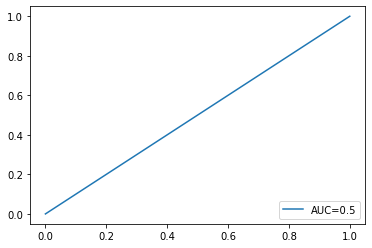


******** For i = 0.2 ******
0.11736876541345816
Precision= 0.11736876541345816
Recal= 0.11736876541345816
fscore= 0.03064790426466511
Confusion Matrix = [[   73 17533]
 [    4  2259]]


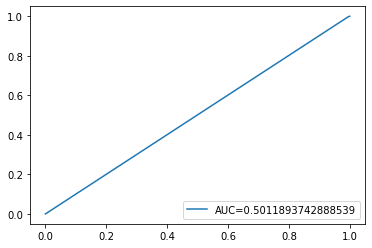


******** For i = 0.25 ******
0.13362524535708895
Precision= 0.13362524535708895
Recal= 0.13362524535708895
fscore= 0.06376752533178645
Confusion Matrix = [[  409 17197]
 [   17  2246]]


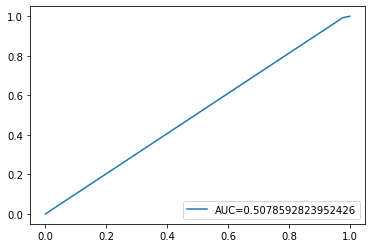


******** For i = 0.3 ******
0.18093512506920328
Precision= 0.18093512506920328
Recal= 0.18093512506920328
fscore= 0.15483811480034002
Confusion Matrix = [[ 1408 16198]
 [   76  2187]]


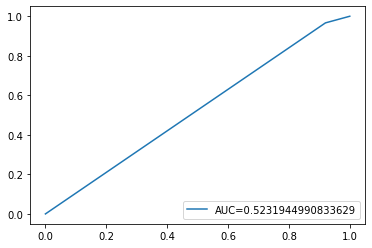

In [51]:
pred_proba_df = pd.DataFrame(grid_search.predict_proba(X_test))
threshold_list = [0.01, 0.1,0.2, 0.25, 0.3]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    accuracy = mt.accuracy_score(y_test, Y_test_pred.iloc[:,1])
    print(accuracy)
    precision = mt.precision_score(y_test, Y_test_pred.iloc[:,1], average='micro')
    print("Precision=", precision)
    recal = mt.recall_score(y_test, Y_test_pred.iloc[:,1], average='micro')
    print("Recal=", recal)
    fscore = mt.f1_score(y_test, Y_test_pred.iloc[:,1], average='weighted')
    print("fscore=",fscore )
    # Confusion matrix
    cm= confusion_matrix(y_test, Y_test_pred.iloc[:,1])
    print("Confusion Matrix =", cm)
    fpr, tpr, _ = roc_curve(y_test, Y_test_pred.iloc[:,1])
    auc = roc_auc_score(y_test, Y_test_pred.iloc[:,1])
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.legend(loc=4)
    plt.show()
    